# Xác định vị trí S-Nitrosyl hóa trong protein

 Nguyễn Hồng Quang
 
 Khoa Kỹ thuật máy tính
 
 Trường Công nghệ thông tin và Truyền thông
 
 Trường Đại học Bách Khoa Hà Nội
 
 Tháng 12 / 2021

 Reference: https://ieeexplore.ieee.org/abstract/document/9313999/media#media
A. Siraj, T. Chantsalnyam, H. Tayara and K. T. Chong, "RecSNO: Prediction of Protein S-Nitrosylation Sites Using a Recurrent Neural Network," in IEEE Access, vol. 9, pp. 6674-6682, 2021, doi: 10.1109/ACCESS.2021.3049142.

# Bài toán:
Một chuỗi 41 ký tự với ký tự C ở giữa

Ví dụ: MAQDQGEKENPMRELRIRKLCLNICVGESGDRLTRAAKVLE

Phải phân loại chuỗi này thành 2 loại: nonSNO và SNO 

# Dataset: 
Tập dữ liệu training: 3383 positive and 3365 negative sites (hiện tại đã có)

Tập dữ liệu test: contain 351 positive and 3168 negative sites (hiện tại chưa có, mới chỉ có vị trí ở trong file S-nitrosylation datasets-PreSNO_test.csv )



In [2]:
from sklearn.preprocessing import LabelEncoder
import numpy as np
from keras.models import Model
from keras.regularizers import l2
from keras.constraints import max_norm
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from keras.layers import Input, Dense, Dropout, Flatten, Activation
from keras.layers import Conv1D, Add, MaxPooling1D, BatchNormalization
from keras.layers import Embedding, Bidirectional, CuDNNLSTM, GlobalMaxPooling1D, LSTM
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

import pandas as pd
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [3]:
file_test = "test.csv"
file_train = "train.csv"

In [4]:
# dataset tổ chức như một dictionary, gồm có 2 keys: sequences và labels
# + sequences : là một list các sequences
# + labels: là một list các labels "+1" cho postive và "-1" cho negative
def read_file_dataset(file_dataset): 
    nb_positive = 0
    nb_negative = 0
    
    dataset = {}
    dataset["sequences"] = []
    dataset["labels"] = []
    
    f = open(file_dataset, "r")
    lines = f.readlines()
    f.close()
    
    print(lines[0])
    print(lines[1])
    print(lines[2])
    
    print("Tổng số chuỗi: ", len(lines) - 2)
    
    for line in lines[2:]:
        seq = line.strip().split(",")[3]
        #print(seq)
        label = line.strip().split(",")[2]
        #print(label)
        
        if label == "SNO": nb_positive += 1
        if label == "nonSNO": nb_negative += 1
        
        dataset["sequences"].append(seq)
        dataset["labels"].append(label)
        
        #break
    
    print("Tổng số mẫu positive: ", nb_positive)
    print("Tổng số mẫu negative: ", nb_negative)
    
    return dataset
    

In [5]:
dataset = read_file_dataset(file_train)
print('-'*70)
test = read_file_dataset(file_test)

,Training DataSet,,

Protein_ID,Location,Status,Fragment

P04117,118,SNO,WDGKSTTIKRKRDGDKLVVECVMKGVTSTRVYERA------

Tổng số chuỗi:  6748
Tổng số mẫu positive:  3383
Tổng số mẫu negative:  3365
----------------------------------------------------------------------
,Independent DataSet,,

Protein_ID,Location,Status,Fragment

Q810U3,118,SNO,TLVIDFRSGGRPEEYEGEYQCFARNKFGTALSNRIRLQVSK

Tổng số chuỗi:  3519
Tổng số mẫu positive:  351
Tổng số mẫu negative:  3168


In [6]:
X = dataset['sequences']
X_test = test['sequences']
y = dataset['labels']
y_test = test['labels']


Mã hóa các 23 amino axit và kí tự '-' thành các 

In [8]:
# codes = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
#          'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U','V', 'W', 'Y', '-']

codes = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
         'M', 'N', 'P', 'Q', 'R', 'S', 'T','V', 'W', 'Y', '-']
def create_dict(codes):
  char_dict = {}
  for index, val in enumerate(codes):
    char_dict[val] = index+1

  return char_dict

char_dict = create_dict(codes)

print(char_dict)
print("Dict Length:", len(char_dict))

{'A': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'V': 18, 'W': 19, 'Y': 20, '-': 21}
Dict Length: 21


In [9]:


def integer_encoding(data):
  """
  - Encodes code sequence to integer values.
  - 20 common amino acids are taken into consideration
    and rest 4 are categorized as 0.
  """
  
  encode_list = []
  for i in range(len(data)):
    row_encode = []
#     for code in row:
#       
#     encode_list.append(np.array(row_encode))
    for x in data[i]:
        row_encode.append(char_dict.get(x, 0))
    encode_list.append(np.array(row_encode))
    
  
  return np.asarray(encode_list)
  
X_encode = integer_encoding(X)
X_test_encode = integer_encoding(X_test)
# val_encode = integer_encoding(val_sm) 
# test_encode = integer_encoding(test_sm) 

In [10]:
max_length = 41
X_pad = pad_sequences(X_encode, maxlen=max_length, padding='post', truncating='post')
X_ohe = to_categorical(X_pad)
X_pad.shape, X_ohe.shape

X_test_pad = pad_sequences(X_test_encode, maxlen=max_length, padding='post', truncating='post')
X_test_ohe = to_categorical(X_test_pad)


In [11]:
out_encoder = LabelEncoder()
y_le = out_encoder.fit_transform(y)
y_test_le = out_encoder.transform(y_test)
# print(y_test)

In [12]:
y_cate = to_categorical(y_le)
y_test_cate = to_categorical(y_test_le)

In [13]:
def display_model_score(model, train, val, batch_size):

  train_score = model.evaluate(train[0], train[1], batch_size=batch_size, verbose=1)
  print('Train loss: ', train_score[0])
  print('Train accuracy: ', train_score[1])
  print('-'*70)

  val_score = model.evaluate(val[0], val[1], batch_size=batch_size, verbose=1)
  print('Val loss: ', val_score[0])
  print('Val accuracy: ', val_score[1])
  print('-'*70)
  

#   test_score = model.evaluate(test[0], test[1], batch_size=batch_size, verbose=1)
#   print('Test loss: ', test_score[0])
#   print('Test accuracy: ', test_score[1])
  return val_score[0], val_score[1]
    

In [14]:
from math import sqrt 

def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==0:
           TP += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==1:
           TN += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FN += 1

    SN=TP/(TP+FN)
    SP=TN/(TN+FP)
    ACC=(TP+TN)/(TP+TN+FP+FN)
    MCC=(TN*TP-FN*FP)/sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))
    
    print("TP: ", TP, " FP: ", FP, " TN: ", TN, " FN: ",FN)
    return(SN, SP, ACC, MCC)

In [15]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.xlabel('epoch')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('epoch')
    plt.legend()

In [16]:
X_train, X_val, y_train, y_val = train_test_split(X_pad, y_cate, test_size=0.2, random_state=1)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [17]:
es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

In [29]:
x_input = Input(shape=(41,))

emb = Embedding(22, 64, input_length=max_length)(x_input)

bi_rnn1 = Bidirectional(LSTM(128, kernel_regularizer=l2(0.0001), recurrent_regularizer=l2(0.0001), bias_regularizer=l2(0.0001), return_sequences=True))(emb)

dropout1 = Dropout(0.1)(bi_rnn1)

bi_rnn2 = Bidirectional(LSTM(64, kernel_regularizer=l2(0.0001), recurrent_regularizer=l2(0.0001), bias_regularizer=l2(0.0001), return_sequences=True))(dropout1)

dropout2 = Dropout(0.2)(bi_rnn2)

bi_rnn3 = Bidirectional(LSTM(32, kernel_regularizer=l2(0.0001), recurrent_regularizer=l2(0.0001), bias_regularizer=l2(0.0001), return_sequences=True))(dropout2)

dropout3 = Dropout(0.2)(bi_rnn3)

maxpooling=MaxPooling1D(pool_size=2)(dropout3)

flatten = Flatten()(maxpooling)

x = Dropout(0.2)(flatten)
# softmax classifier
x_output = Dense(2, activation='softmax')(x)

model1 = Model(inputs=x_input, outputs=x_output)
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model1.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 41)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 41, 64)            1408      
_________________________________________________________________
bidirectional_4 (Bidirection (None, 41, 256)           197632    
_________________________________________________________________
dropout_5 (Dropout)          (None, 41, 256)           0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 41, 128)           164352    
_________________________________________________________________
dropout_6 (Dropout)          (None, 41, 128)           0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 41, 64)            4121

In [30]:
history1 = model1.fit(
    X_train, y_train,
    epochs=25, batch_size=256,
    validation_data=(X_val, y_val),
    # callbacks=[es]
    )

Train on 5398 samples, validate on 1350 samples
Epoch 1/25
5398/5398 [==============================] - 24s 5ms/step - loss: 0.8362 - accuracy: 0.5741 - val_loss: 0.7933 - val_accuracy: 0.6252
Epoch 2/25
5398/5398 [==============================] - 20s 4ms/step - loss: 0.7592 - accuracy: 0.6371 - val_loss: 0.7152 - val_accuracy: 0.6793
Epoch 3/25
5398/5398 [==============================] - 22s 4ms/step - loss: 0.7159 - accuracy: 0.6510 - val_loss: 0.7044 - val_accuracy: 0.6719
Epoch 4/25
5398/5398 [==============================] - 29s 5ms/step - loss: 0.6997 - accuracy: 0.6526 - val_loss: 0.6827 - val_accuracy: 0.6800
Epoch 5/25
5398/5398 [==============================] - 28s 5ms/step - loss: 0.6886 - accuracy: 0.6619 - val_loss: 0.6699 - val_accuracy: 0.6763
Epoch 6/25
5398/5398 [==============================] - 27s 5ms/step - loss: 0.6727 - accuracy: 0.6680 - val_loss: 0.6742 - val_accuracy: 0.6674
Epoch 7/25
5398/5398 [==============================] - 26s 5ms/step - loss: 0.667

In [31]:
display_model_score(model1,
    [X_train, y_train],
    [X_test_pad, y_test_cate],
    256)

5398/5398 [==============================] - 4s 824us/step
Train loss:  0.6050922799083912
Train accuracy:  0.7104483246803284
----------------------------------------------------------------------
3519/3519 [==============================] - 3s 821us/step
Val loss:  0.673529106959527
Val accuracy:  0.6183574795722961
----------------------------------------------------------------------


(0.673529106959527, 0.6183574795722961)

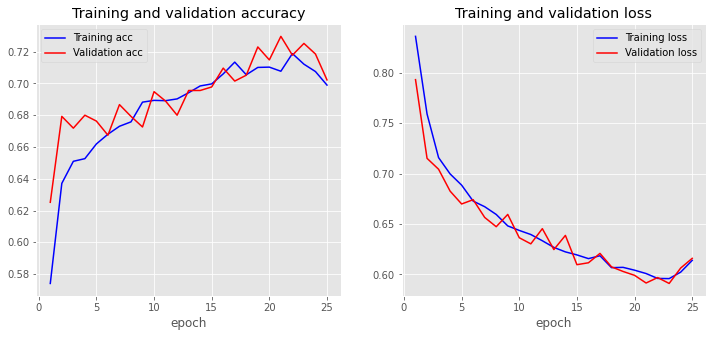

In [32]:
plot_history(history1)

In [33]:
yhat_train = model1.predict(X_train)
perf_measure(y_train.argmax(axis=-1),yhat_train.argmax(axis=-1))

TP:  2443  FP:  1294  TN:  1392  FN:  269


(0.900811209439528, 0.5182427401340283, 0.7104483141904409, 0.4539640060580911)

In [34]:
yhat_test = model1.predict(X_test_pad)
perf_measure(y_test_cate.argmax(axis=-1),yhat_test.argmax(axis=-1))

TP:  309  FP:  1301  TN:  1867  FN:  42


(0.8803418803418803,
 0.5893308080808081,
 0.6183574879227053,
 0.28250461644080144)

In [109]:
def plot_roc_auc_curve(fpr, tpr, roc_auc, title): 
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for ' + title)
    plt.legend(loc="lower right")
    plt.show()

0.7949558800253245


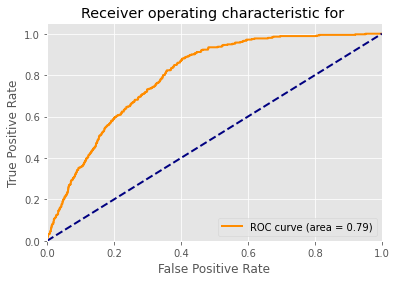

In [112]:
auc = roc_auc_score(y_test_cate, yhat_test)
print(auc)
fpr, tpr, _ = roc_curve(y_test_cate[:,0], yhat_test[:,0])
plot_roc_auc_curve(fpr, tpr, auc, "")

In [17]:
from sklearn.model_selection import KFold

In [18]:
inputs = np.concatenate((X_train, X_val), axis=0)
targets = np.concatenate((y_train, y_val), axis=0)

In [43]:
kfold = KFold(n_splits=5, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1

acc_per_fold=[]
loss_per_fold=[]
measure = []

for train, test in kfold.split(inputs, targets):
    x_input = Input(shape=(41,))

    emb = Embedding(24, 64, input_length=max_length)(x_input)

    bi_rnn1 = Bidirectional(LSTM(64, kernel_regularizer=l2(0.0001), recurrent_regularizer=l2(0.0001), bias_regularizer=l2(0.0001), return_sequences=True))(emb)

    dropout1 = Dropout(0.1)(bi_rnn1)

    bi_rnn2 = Bidirectional(LSTM(32, kernel_regularizer=l2(0.0001), recurrent_regularizer=l2(0.0001), bias_regularizer=l2(0.0001), return_sequences=True))(dropout1)

    dropout2 = Dropout(0.2)(bi_rnn2)

    bi_rnn3 = Bidirectional(LSTM(24, kernel_regularizer=l2(0.0001), recurrent_regularizer=l2(0.0001), bias_regularizer=l2(0.0001), return_sequences=True))(dropout2)

    dropout3 = Dropout(0.2)(bi_rnn3)

    maxpooling=MaxPooling1D(pool_size=2)(dropout3)

    flatten = Flatten()(maxpooling)

    x = Dropout(0.2)(flatten)
    # softmax classifier
    x_output = Dense(2, activation='softmax')(x)

    model = Model(inputs=x_input, outputs=x_output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#     model.summary()
    
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    fold_no += 1
    history = model.fit(
    inputs[train], targets[train],
    epochs=20, batch_size=256,
    validation_data=(inputs[test], targets[test]),
#     callbacks=[es]
    )
    
    scores=display_model_score(model,
    [inputs[train], targets[train]],
    [inputs[test], targets[test]],
    256)
    
    target_hat = model.predict(inputs[test])
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    measure.append(perf_measure(targets[test].argmax(axis=-1),target_hat.argmax(axis=-1)))

------------------------------------------------------------------------
Training for fold 1 ...
Train on 5398 samples, validate on 1350 samples
Epoch 1/20
5398/5398 [==============================] - 36s 7ms/step - loss: 0.7848 - accuracy: 0.5317 - val_loss: 0.7383 - val_accuracy: 0.6207
Epoch 2/20
5398/5398 [==============================] - 28s 5ms/step - loss: 0.7097 - accuracy: 0.6278 - val_loss: 0.6747 - val_accuracy: 0.6504
Epoch 3/20
5398/5398 [==============================] - 28s 5ms/step - loss: 0.6785 - accuracy: 0.6665 - val_loss: 0.6575 - val_accuracy: 0.6711
Epoch 4/20
5398/5398 [==============================] - 28s 5ms/step - loss: 0.6625 - accuracy: 0.6647 - val_loss: 0.6646 - val_accuracy: 0.6504
Epoch 5/20
5398/5398 [==============================] - 28s 5ms/step - loss: 0.6581 - accuracy: 0.6721 - val_loss: 0.6438 - val_accuracy: 0.6711
Epoch 6/20
5398/5398 [==============================] - 28s 5ms/step - loss: 0.6447 - accuracy: 0.6708 - val_loss: 0.6412 - val_ac

Epoch 9/20
5398/5398 [==============================] - 38s 7ms/step - loss: 0.6303 - accuracy: 0.6790 - val_loss: 0.6250 - val_accuracy: 0.6807
Epoch 10/20
5398/5398 [==============================] - 34s 6ms/step - loss: 0.6219 - accuracy: 0.6890 - val_loss: 0.6252 - val_accuracy: 0.6919
Epoch 11/20
5398/5398 [==============================] - 36s 7ms/step - loss: 0.6209 - accuracy: 0.6938 - val_loss: 0.6151 - val_accuracy: 0.6889
Epoch 12/20
5398/5398 [==============================] - 37s 7ms/step - loss: 0.6101 - accuracy: 0.6888 - val_loss: 0.6190 - val_accuracy: 0.6904
Epoch 13/20
5398/5398 [==============================] - 41s 8ms/step - loss: 0.6070 - accuracy: 0.6953 - val_loss: 0.6112 - val_accuracy: 0.7022
Epoch 14/20
5398/5398 [==============================] - 37s 7ms/step - loss: 0.5970 - accuracy: 0.7110 - val_loss: 0.6079 - val_accuracy: 0.6978
Epoch 15/20
5398/5398 [==============================] - 46s 8ms/step - loss: 0.6047 - accuracy: 0.7016 - val_loss: 0.6153 - 

Epoch 18/20
5399/5399 [==============================] - 35s 6ms/step - loss: 0.5925 - accuracy: 0.7124 - val_loss: 0.6436 - val_accuracy: 0.6701
Epoch 19/20
5399/5399 [==============================] - 35s 6ms/step - loss: 0.5885 - accuracy: 0.7135 - val_loss: 0.6210 - val_accuracy: 0.6864
Epoch 20/20
5399/5399 [==============================] - 12s 2ms/step
Train loss:  0.5886034377417447
Train accuracy:  0.7119836807250977
----------------------------------------------------------------------
1349/1349 [==============================] - 3s 2ms/step
Val loss:  0.6293220210287463
Val accuracy:  0.6723498702049255
----------------------------------------------------------------------


In [46]:
print (acc_per_fold)

[70.44444680213928, 69.11110877990723, 71.40740752220154, 70.20015120506287, 67.23498702049255]


In [47]:
print(loss_per_fold)

[0.5926436153164616, 0.6018155544775504, 0.5942034248069481, 0.6389218019590809, 0.6293220210287463]


In [48]:
print (measure)

[(0.5926436153164616, 0.7044444680213928), (0.6018155544775504, 0.6911110877990723), (0.5942034248069481, 0.7140740752220154), (0.6389218019590809, 0.7020015120506287), (0.6293220210287463, 0.6723498702049255)]


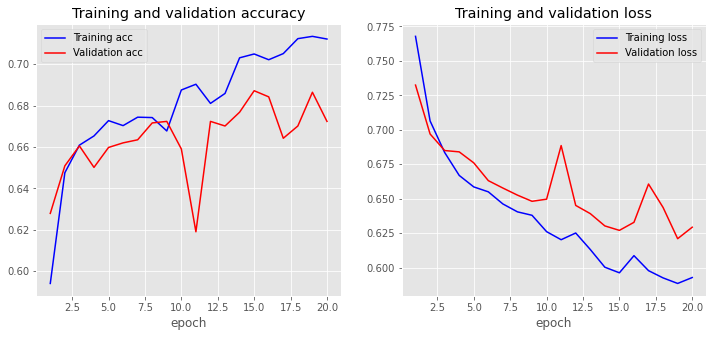

In [49]:
plot_history(history)